In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import sys
import os
import subprocess

from six import string_types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

# Step 1. Exploratory Data Analysis (EDA)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
data_dir_list = os.listdir('../input/planets-dataset/planet/planet')
print(data_dir_list)
path, dirs, files = next(os.walk("../input/planets-dataset/planet/planet"))
file_count = len(files)


In [ ]:
PLANET_KAGGLE_ROOT = os.path.abspath("../input/planets-dataset/planet/planet/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_classes.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [ ]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

In [ ]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

In [ ]:

label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
label_list

In [ ]:

for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
labels_df.head()

In [ ]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [ ]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
make_cooccurence_matrix(label_list)

# Training

In [ ]:
!pip install fastai --upgrade -q
from fastai.vision.all import *

!pip install wwf -q
!pip install timm -q
from wwf.vision.timm import *

In [ ]:

path = Path('../input/planets-dataset/planet/planet')

In [ ]:
train_df = pd.read_csv(os.path.join(PLANET_KAGGLE_ROOT, 'train_classes.csv'))
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
def get_x(df):
    return path/'train-jpg'/(df['image_name']+'.jpg')

def get_y(df):
    return df['tags'].split()

def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x, 
                       get_y=get_y,
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True,max_warp=0),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [ ]:
dls = get_data(300,40)

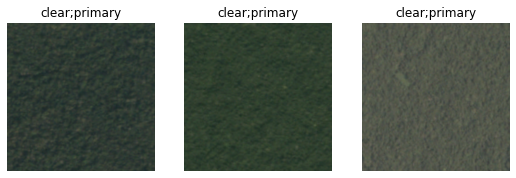

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
f2samples = FBetaMulti(beta=2,average='samples',thresh=0.2)

metrics = [partial(accuracy_multi, thresh=0.2), f2samples]
cbs = [MixUp]

In [ ]:
learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=cbs)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [ ]:
learn.fine_tune(12, base_lr=3e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.183427,0.470039,0.924020,0.874895,06:55


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.147828,0.768649,0.950790,0.907580,08:42


In [ ]:
file_path = Path('../input/planets-dataset/test-jpg-additional/test-jpg-additional')
test_path = Path('../input/planets-dataset/planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else file_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [ ]:
prediction('Planet_submission.csv', tta=True)

In [ ]:
import gc
gc.collect()

23